# TP2: Image-to-sequence (Handwritten Text Recognition)

## Goals
- Implement transformer-based model for an image-to-sequence task
- Visualize attention maps


We will use a modified version of the MNIST dataset with multiple digits within the same image. The goal is to train a model to recognize all digits in the correct order (from left to right).

In [3]:
# Config used: torch==2.4.1 

# Download the data
!wget -nc https://people.irisa.fr/Denis.Coquenet/courses/content/M2-DLV/TP2/mnist_variable_len_1k.data

File ‘mnist_variable_len_1k.data’ already there; not retrieving.



In [4]:
# Making experiment reproducible
import torch
import numpy as np

def set_deterministic():
    torch.manual_seed(0)
    torch.cuda.manual_seed(0)
    np.random.seed(0)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

set_deterministic()

# Dataset

This part focuses on defining the custom dataset with images of variable widths (containing between 1 and 5 concatenated MNIST digits).  

You have nothing to code here by yourself.  

TODO: read and understand how the dataset is handled.  

In [5]:
from torch.utils.data import Dataset

class MNISTDataset(Dataset):
    """
    Custom dataset class to manipulate a specific version of the MNIST dataset in which samples consists in the concatenation of single digits from the original MNIST dataset.
    """

    pad_label_value = None

    def __init__(self, filepath, set_name):
        self.set_name = set_name
        data = torch.load(filepath)
        self.classes = data["classes"]  # associate each class to an int
        self.samples = data[f"{set_name}_samples"]  # the input images (containing between 1 and 5 digits)
        self.targets = data[f"{set_name}_targets"]  # the expected output (numpy array of class indices)
        
        self.token_set = [c[0] for c in self.classes] + ["<e>", "<b>", "<p>"]  # digits + begin / end / padding special tokens
        if MNISTDataset.pad_label_value is None:
           MNISTDataset.pad_label_value = self.token_set.index("<p>")

        self.samples = [torch.tensor(s, dtype=torch.float).unsqueeze(0) for s in self.samples]  # preprocess the inputs once and for all
        self.targets = [self.preformat_label(t) for t in self.targets]  # preprocess the targets once and for all

    def __len__(self):
        """
        Compute the number of samples in the dataset
        """
        return len(self.samples)

    def __getitem__(self, idx):
        """
        Return the sample at index idx (input and ground truth) as a dict
        """
        return {
            "input_img": self.samples[idx], 
            "ground_truth": self.targets[idx]
        }
    
    def preformat_label(self, label):
        """
        Format the labels to process them in an image-to-sequence task.
        It casts the label from numpy to torch and adds a <b> token before
        the label tokens, and a <e> token after.
        """
        new_label = torch.ones((len(label)+2), dtype=torch.long)
        new_label[0] = self.token_set.index("<b>")
        new_label[1:-1] = torch.tensor(label)
        new_label[-1] = self.token_set.index("<e>")
        return new_label
    
    def decode_tokens(self, tokens):
        """
        tokens: iterable of int
        Return the string corresponding to the token sequence
        """
        return [self.token_set[i] for i in tokens if i <= 10]

    @staticmethod
    def pad_images(img_list, padding_value):
        """
        Function that puts some torch images together to process them as a mini-batch.
        Smaller images are padded.
        A torch image size is as follows (C, H, W)
        H: height, W: width, C: number of channels (1 for grayscale, 3 for RGB)
        """
        num_imgs = len(img_list)
        channels = img_list[0].size(0)
        height = img_list[0].size(1)
        max_width = max([img.size(2) for img in img_list])
        batch_imgs = torch.full(size=(num_imgs, channels, height, max_width), 
                                fill_value=padding_value,
                                dtype=img_list[0].dtype)
        for i, img in enumerate(img_list):
            batch_imgs[i, 0, :, :img.size(2)] = img
        return batch_imgs
    
    @classmethod
    def pad_labels(cls, label_list):
        """
        Function that puts some labels together to process them as a mini-batch.
        Shorter labels are padded.
        batch_data: list of list of int
        """
        num_labels = len(label_list)
        max_len = max([label.size(0) for label in label_list])
        batch_labels = torch.full(size=(num_labels, max_len),
                                  fill_value=cls.pad_label_value,
                                  dtype=label_list[0].dtype)
        for i, label in enumerate(label_list):
            batch_labels[i, :label.size(0)] = label 
        return batch_labels
    
    @staticmethod
    def batch_samples(batch_data):
        """
        Function that puts some samples together to process them as a mini-batch.
        batch_data: list of samples
        """
        input_imgs = [data["input_img"] for data in batch_data]
        ground_truths = [data["ground_truth"] for data in batch_data]
        return {
            "imgs": MNISTDataset.pad_images(input_imgs, padding_value=0),
            "labels": MNISTDataset.pad_labels(ground_truths),
            "original_widths": [data["input_img"].size(2) for data in batch_data],
            "label_lengths": [data["ground_truth"].size(0) for data in batch_data],
        }

In [6]:
from torch.utils.data import DataLoader
train_dataset = MNISTDataset(set_name="train", filepath="./mnist_variable_len_1k.data")
train_dataloader = DataLoader(dataset=train_dataset, 
                              batch_size=512, 
                              shuffle=True,
                              collate_fn=MNISTDataset.batch_samples)


# Let's check the first mini-batch
for batch_data in train_dataloader:
    x = batch_data["imgs"]
    y = batch_data["labels"]
    print(x.size(), y.size())
    break

torch.Size([512, 1, 32, 160]) torch.Size([512, 7])


/tmp/ipykernel_21269/2784281161.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(filepath)


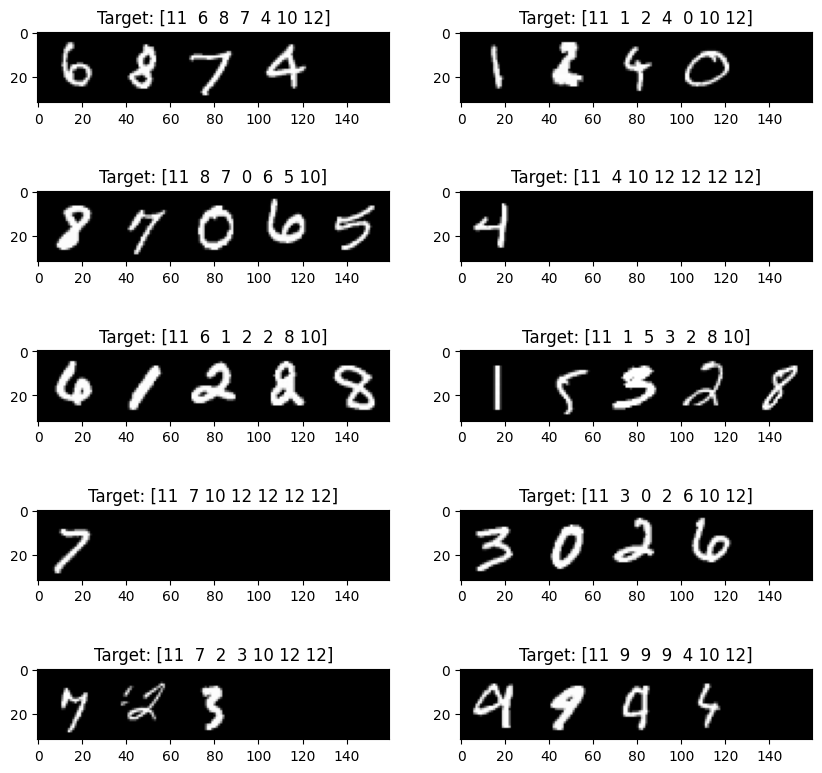

In [7]:
# Let's display some samples
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(10, 10))
for i in range(5):
    for j in range(2):
        sample_index = 5*j+i
        axes[i][j].imshow(x[sample_index, 0], cmap="gray")
        axes[i][j].set_title(f"Target: {y[sample_index].numpy()}")
plt.show()

# Architecture

We will follow the architecture of the Document Attention Network, i.e., we will rely on an FCN encoder and a transformer decoder to handle this image-to-sequence task.  

We will follow a step-by-step strategy to design the network, successively focusing on the different components:  
- The fully convolutional network encoder  
- The transformer decoder  
- The positional encoding  
- Finally, merging all of these together  

<img src="https://people.irisa.fr/Denis.Coquenet/courses/content/M2-DLV/TP2/DAN_model.png" height="600"/>  <br/>

### Encoder

We will rely on a rather simple encoder made up of some convolutional layers. It aims at extracting 2D features from the input image.  

**TODO**: based on the convolutional layer configurations, compute the downsampling factor applied by the encoder, i.e., by which factor the height and the width of the input image are divided (replace the ??? in the following cell).


In [8]:
from torch.nn import Module, InstanceNorm2d, Conv2d, ReLU

class FCN_Encoder(Module):
    """
    This encoder will take as input images of size (32, N*32), N being the number of digits in the image
    and output features of size (1, N)
    """

    downsampling_factor = 16

    def __init__(self, out_dim):
        super().__init__()
        start_dim=32
        self.conv1 = Conv2d(in_channels=1, out_channels=start_dim, kernel_size=2, stride=2, padding=0)  # dim/2
        self.conv2 = Conv2d(in_channels=start_dim, out_channels=2*start_dim, kernel_size=2, stride=2, padding=0)  # dim/2
        self.conv3 = Conv2d(in_channels=2*start_dim, out_channels=4*start_dim, kernel_size=2, stride=2, padding=0) # dim/2
        self.conv4 = Conv2d(in_channels=4*start_dim, out_channels=out_dim, kernel_size=2, stride=2, padding=0) # dim/2

        self.norm1 = InstanceNorm2d(2*start_dim)
        self.norm2 = InstanceNorm2d(4*start_dim)
        self.activation = ReLU()


    def forward(self, x):
        x = self.activation(self.conv1(x))
        x = self.activation(self.conv2(x))
        x = self.norm1(x)
        x = self.activation(self.conv3(x))
        x = self.norm2(x)
        x = self.activation(self.conv4(x))
        return x

### Transformer Decoder

The goal now is to implement a transformer decoder layer (we will only use one layer in the network). Its goal is to iteratively apply the transformer attention mechanisms to focus on a specific part of the input image.  

To do so, the transformer decoder relies on two kinds of attention:  
- the self-attention, which is applied between a set of tokens, and itself (queries, keys and values are from the same source).  
- the cross attention, which is applied between two sets of tokens (queries are from source tokens, and keys and values are from target tokens).  

When performing these attention mechanisms, it is important to mask some tokens to avoid accessing padding tokens, whether it is from the source (text tokens), or from the target (image tokens).  

Also, when applying teacher forcing, it is required to mask "the future", so the mask remains causal in the self-attention.  

TODO: implement these mask functions.


In [9]:
# L: length of the token sequence, B: mini-batch size, H: height of the image, W: width of the image

class MaskHelper:

    @staticmethod
    def compute_tgt_padding_mask(target_text_sequence, target_lengths):
        """
        Compute the mask of valid position for the target text sequence       
        target_text_sequence: tensor of size (L, B, C)
        target_lengths: list of int
        True = padded location, False = real text token location
        Return tensor of size (B, L)
        """
        L, B, C = target_text_sequence.size()
        mask = torch.ones((B, L), dtype=torch.bool)
        for i, len_ in enumerate(target_lengths):
            mask[i, :len_] = False
        return mask
    
    @staticmethod
    def compute_image_padding_mask(batch_img_features, original_widths, downsampling_factor):
        """
        Compute the mask of valid position for the image
        batch_img_features: tensor of size (B, C, H, W)
        original_widths: list of int
        downsampling_factor: int
        Must return a boolean flattened tensor of shape (B, H, W)
        True = padded location, False = real image location
        """
        B, C, H, W = batch_img_features.size()
        mask = torch.ones((B, H, W), dtype=torch.bool)
        for i, width in enumerate(original_widths):
            mask[i, :, :width//downsampling_factor] = False
        return mask
    
    
    @staticmethod
    def compute_tgt_attn_mask(target_text_sequence):
        """
        target_text_sequence: tensor of size (L, B, C)
        Return a mask tensor of size (L, L) indicating which text token can attend to which text tokens in self-attention
        mask[i, j] specifies if token i can attend to token j
        False = can attend, True = cannot attend
        """
        len_ = target_text_sequence.size(0)
        return torch.triu(torch.ones((len_, len_), dtype=torch.bool), diagonal=1)


Let's check the mask functions

In [10]:
# visualizing tgt_attn_mask

L = 5
B = 4
C = 256
H = 32
W = 160
Hf, Wf = H // FCN_Encoder.downsampling_factor, W // FCN_Encoder.downsampling_factor

target = torch.zeros((L, B, C))  
target_len = torch.tensor([5, 2, 2, 3])  # (B, )
images = torch.zeros((B, C, Hf, Wf))
original_widths = torch.tensor([160, 64, 64, 96])  # (B, )

tgt_attn_mask = MaskHelper.compute_tgt_attn_mask(target)  # (L, L)

print(tgt_attn_mask)

tensor([[False,  True,  True,  True,  True],
        [False, False,  True,  True,  True],
        [False, False, False,  True,  True],
        [False, False, False, False,  True],
        [False, False, False, False, False]])


In [11]:
# visualizing tgt_pad_mask
tgt_pad_mask = MaskHelper.compute_tgt_padding_mask(target, target_len)  # (B, L)
print(tgt_pad_mask)

tensor([[False, False, False, False, False],
        [False, False,  True,  True,  True],
        [False, False,  True,  True,  True],
        [False, False, False,  True,  True]])


In [12]:
# visualizing memory_pad_mask
memory_pad_mask = MaskHelper.compute_image_padding_mask(images, original_widths, FCN_Encoder.downsampling_factor)  # (B, Hf, Wf)
torch.set_printoptions(profile="full")
print(memory_pad_mask)



tensor([[[False, False, False, False, False, False, False, False, False, False],
         [False, False, False, False, False, False, False, False, False, False]],

        [[False, False, False, False,  True,  True,  True,  True,  True,  True],
         [False, False, False, False,  True,  True,  True,  True,  True,  True]],

        [[False, False, False, False,  True,  True,  True,  True,  True,  True],
         [False, False, False, False,  True,  True,  True,  True,  True,  True]],

        [[False, False, False, False, False, False,  True,  True,  True,  True],
         [False, False, False, False, False, False,  True,  True,  True,  True]]])


#### Transformer decoder layer

We now focus on the decoder layer itself. We will rely on the multi-head attention implementation of Pytorch.   

In the following cell, layers are already initialized with appropriate parameters.  

**TODO**: based on the Document Attention Network figure (gray box), implement the forward function. 

Documentation for the used layers can be found here: [MultiheadAttention](https://pytorch.org/docs/stable/generated/torch.nn.MultiheadAttention.html), [Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear), [LayerNorm](https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html#torch.nn.LayerNorm), [ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html)

In [13]:
from torch.nn import MultiheadAttention, Linear, LayerNorm, ReLU

class TransformerDecoder(Module):

    def __init__(self, embed_dim, num_heads=2, dim_feedforward=128):
        super().__init__()
        self.cross_attention = MultiheadAttention(embed_dim, 
                                                  num_heads=num_heads)
        
        self.norm1 = LayerNorm(embed_dim)
        self.self_attention = MultiheadAttention(embed_dim, 
                                                  num_heads=num_heads)
        self.norm2 = LayerNorm(embed_dim)
        
        # feedforward is defined as an MLP
        self.linear1 = Linear(embed_dim, dim_feedforward)
        self.activation = ReLU()
        self.linear2 = Linear(dim_feedforward, embed_dim)

        self.norm3 = LayerNorm(embed_dim)

    def forward(self, tgt, memory, tgt_mask=None, memory_mask=None,
                tgt_key_padding_mask=None, memory_key_padding_mask=None):
        """
        tgt: target text sequence (Lt, B, C)
        memory: flattened image features (Li, B, C)
        tgt_mask: mask for the target (which item can attend to which one, useful for teacher forcing) - bool tensor (Lt, Lt)
        memory_mask: mask for the image features (Li, Li) - not useful here as no self attention over the image
        tgt_key_padding_mask: mask to discard padded position in target - bool tensor (B, Lt)
        memory_key_padding_mask: mask to discard padded position in features - bool tensor (B, Li)
        
        Output: tuple including
        - the output sequence (Lt, B, C)
        - the attention weights of the cross-attention layer (B, Lt, Li)
        """
        
        new_tgt, _ = self.self_attention(query=tgt,
                                      key=tgt,
                                      value=tgt,
                                      attn_mask=tgt_mask,
                                      key_padding_mask=tgt_key_padding_mask,
                                      need_weights=False,
        )
        tgt = self.norm1(new_tgt + tgt)

        new_tgt, attn_weights = self.cross_attention(query=tgt,
                                    key=memory,
                                    value=memory,
                                    attn_mask=memory_mask,
                                    key_padding_mask=memory_key_padding_mask,
                                    need_weights=True,
        )

        tgt = self.norm2(new_tgt + tgt)
        new_tgt = self.linear2(self.activation(self.linear1(tgt)))
        tgt = self.norm3(new_tgt + tgt)
        return tgt, attn_weights

### Positional encoding

The multi-head attention is permutation-equivariant, so we need to inject positional information to the input sets.  
Each position is encoded as a positional embedding vector such that $\text{PE}(p, k)$ corresponds to the $k^\text{th}$ value of the positional embedding vector for position $p$.

The original positional encoding (from transformer paper) is defined as follows:
\begin{equation*}
\begin{split}
  & \mathrm{PE}(p, 2k) = \sin(w_k \cdot p)\\
  & \mathrm{PE}(p, 2k+1) = \cos(w_k \cdot p)\\
\end{split}
\end{equation*}  

$\forall k \in [0, d/2]$, with $w_k = 1/10000^{2k/d}$  

where $d$ is the dimension of the token embedding.

**TODO**: complete the forward function of the following Module.

In [14]:
from torch.nn import Parameter

class PositionalEncoding(Module):

    def __init__(self, dim):
        super().__init__()
        self.dim = dim

        # We use exponential properties for numerical stability
        # w_k = e^(-alog(b)) = e^(log(1/b^a)) = 1/(b^a)
        # with b = 10,000 and a = 2k/d
        a = torch.arange(0., dim, 2) / dim
        b = torch.tensor(10000.0)
        self.wk = Parameter(torch.exp(-a * torch.log(b)).unsqueeze(0), requires_grad=False)  # (1, dim/2)

    def forward(self, indices):
        """
        Input: indices (B, L) - e.g.: [0, 1, 2, 3, ..., L-1]
        Output: positional embedding (B, L, C)
        """
        emb_indices = torch.zeros((indices.size(0), indices.size(1), self.dim), device=indices.device)  # (B, L, C)
        emb_indices[:, :, ::2] = torch.sin(indices.unsqueeze(2) * self.wk)
        emb_indices[:, :, 1::2] = torch.cos(indices.unsqueeze(2) * self.wk)
        return emb_indices

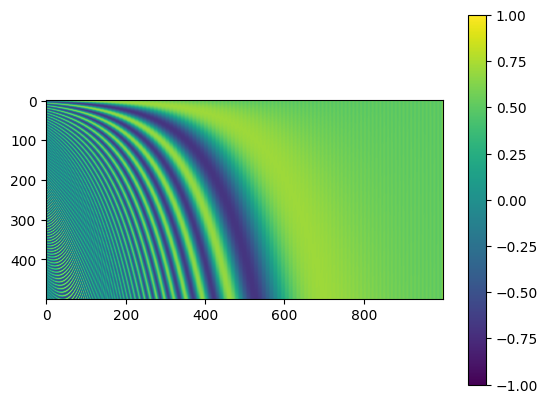

In [15]:
import matplotlib.pyplot as plt

index_sequence = torch.arange(0,500).unsqueeze(0)  # (1, 500)
C = 1000

positional_encoding = PositionalEncoding(C)  
positional_emb = positional_encoding(index_sequence)[0] # (500, 1000)

plt.figure()
plt.imshow(positional_emb)
plt.colorbar()
plt.show()

### Now, let's put all of these components together!

The following cell implements the end-to-end image-to-sequence model.  It takes as input the image, and outputs the predicted text sequence.  

TODO: implement the *decode* function.

In [16]:
from torch.nn import Embedding

class I2SModel(Module):

    """
    The whole image-to-sequence model.
    """

    def __init__(self, token_set, embed_dim=128, max_preds=6):
        super().__init__()
        self.max_preds = max_preds  # set a maximum number of predictions to avoid infinite loops
        self.token_set = token_set  # list of all tokens (digits + special tokens <b>, <e> and <p>)

        self.encoder = FCN_Encoder(embed_dim)  # to extract image features
        self.decoder = TransformerDecoder(embed_dim=embed_dim)  # to iteratively focus on a subpart of the features
        self.positional_encoding = PositionalEncoding(embed_dim)  # to inject positional information in the attention process
        self.emb_layer = Embedding(num_embeddings=len(token_set), embedding_dim=embed_dim)  # to associate a vector embedding to each text token
        self.decision_layer = Linear(in_features=embed_dim, out_features=len(token_set)-2)  # to make token predictions (-2: no need to predict <b> and <p>)


    def forward(self, x, original_widths, tgt=None, tgt_lengths=None):
        """
        x: a mini-batch input tensor of images of variable widths (B, C, H, W)
        original_widths: a list of int (useful for masking)
        tgt: a target mini-batch output tensor of token indices (for training only = teacher forcing) (B, L)
        tgt_lengths: a list of int (target sequences can be of variable lengths, for training only)
        """

        # Encoder part (performed only once)
        features = self.encoder(x)  # extracting features from image (B, dim, H/16, W/16)
        flattened_features = torch.flatten(features, start_dim=2, end_dim=3).permute(2, 0, 1)  # flatten for transformer requirements (Li, B, dim) with Li=(H/16)*(W/16)
        Li, B, C = flattened_features.size()
        img_position = self.generate_positional_embedding(B, Li)  # generate positional embedding
        flattened_features = flattened_features + img_position  # adding positional embedding
        img_pad_mask = MaskHelper.compute_image_padding_mask(features, 
                                                       original_widths, 
                                                       downsampling_factor=self.encoder.downsampling_factor)  # generate mask for features
        img_pad_mask = torch.flatten(img_pad_mask, start_dim=1, end_dim=2)  # flatten mask for transformer requirements (B, Li)
        
        # Decoder part (iterative)
        # The iterative prediction process can be parallelized at training time through teacher forcing, but not at evaluation time
        if tgt is None:
            # eval mode  
            B = x.size(0)
            tgt = torch.full((B, 1), dtype=torch.long, fill_value=self.token_set.index("<b>"))  # start with the <b> token to initiate the decoding stage
            tgt_lengths = [1 for _ in range(B)]  # keep track for prediction lengths
            for i in range(1, self.max_preds+1):  # repeat the decoding step x times
                output, attn_weights = self.decode(tgt, tgt_lengths, flattened_features, img_pad_mask)  # perform one decoding step
                new_pred = torch.argmax(output[:, -1], dim=-1, keepdim=True)  # get the most probable token
                tgt = torch.cat([tgt, new_pred], dim=-1)  # add this most probable token to the target/query sequence
                for j in range(B):  # check for each sample in the mini-batch
                    if tgt_lengths[j] == i and new_pred[j].item() != self.token_set.index("<e>"):  # increase prediction length only if sequence is not already ended (a <e> token has been predicted)
                        tgt_lengths[j] += 1
            
            # Reshape attention weights to get back in 2 dimensions
            B, _, H, W = x.size()
            _, Lt, _ = attn_weights.size() # (B, Lt, Li)
            attn_weights = attn_weights.reshape(B, Lt, H//self.encoder.downsampling_factor, W//self.encoder.downsampling_factor) # (B, Lt, H/16, W/16)

            return tgt, tgt_lengths, attn_weights
        else:  
            # Training mode
            # All predictions are performed at once based on the ground truth, i.e., we use the ground truth as if it was what we predicted so far
            return self.decode(tgt, tgt_lengths, flattened_features, img_pad_mask)
        
    def generate_positional_embedding(self, batch_size, length):
        """
        Compute a positional embedding tensor for position starting from 0 to length-1
        The same positions are used for each sample in the mini-batch.
        """
        positions = torch.arange(0, length)  # [0,1,2,..., length-1]
        batch_positions = torch.repeat_interleave(positions.unsqueeze(1), repeats=batch_size, dim=1)  # (length, batch_size)
        batched_position_emb = self.positional_encoding(batch_positions)  # (length, batch_size, dim)
        return batched_position_emb
        

    def decode(self, tgt, tgt_lengths, features, img_pad_mask):
        """
        tgt: tensor of token indices (B, Lt)
        tgt_lengths: list of int
        features: flattened image features extracted from the encoder (Li, B, C)
        img_pad_mask: bool mask tensor for the flattened features (B, Li)

        Returns a tuple:
        - the predictions of size (B, Lt, N)
        - the attention weights of size (B, Lt, Li)
        """

        # Token indices to token embeddings
        tgt = self.emb_layer(tgt) #  (B, Lt, C)
        tgt = tgt.permute(1, 0, 2) # (Lt, B, C)

        # Adding positional encoding to token embedding
        Lt, B, _ = tgt.size()
        tgt_positional_embedding = self.generate_positional_embedding(B, Lt)
        tgt = tgt + tgt_positional_embedding

        # Compute tgt masks
        tgt_pad_mask = MaskHelper.compute_tgt_padding_mask(tgt, tgt_lengths)  # (B, Lt)
        tgt_attn_mask = MaskHelper.compute_tgt_attn_mask(tgt)  # (Lt, Lt)

        # Apply transformer decoder layer
        output, attn_weights = self.decoder(tgt=tgt,
                                memory=features,
                                tgt_mask=tgt_attn_mask,
                                tgt_key_padding_mask=tgt_pad_mask,
                                memory_mask=None,
                                memory_key_padding_mask=img_pad_mask)
        # output (Lt, B, C)
        # attn_weights (B, Lt, Li)

        # Prediction
        output = output.permute(1, 0, 2) # (B, Lt, C)
        output = self.decision_layer(output) # (B, Lt, N)

        assert not torch.any(torch.isnan(output))  # check that everything worked fine
        return output, attn_weights

# Training

We now have a dataset and a network. Last stage is to train the network on that dataset!  

TODO: implement the *accuracy* function to compute the top-1 accuracy metric, carefully ignoring padding tokens. 

In [17]:
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from tqdm import tqdm
import numpy as np

def accuracy(x, y, padding_value):
    """
    Compute the top-1 accuracy between predictions x (B, L, N) and ground truth y (L, N) 
    B: mini-batch size; L: target sequence length; N: token set size
    """
    mask = y != padding_value  # ignoring padding tokens
    top1_preds = torch.argmax(x, dim=-1)
    return torch.mean(top1_preds[mask] == y[mask], dtype=torch.float).item()

def train(model, dataloader, num_epochs=40):
    """
    Training loop
    """
    optimizer=Adam(model.parameters(), lr=0.001)
    loss_fn = CrossEntropyLoss(ignore_index=MNISTDataset.pad_label_value)
    model.train()
    for i in range(num_epochs):
        losses = []
        accuracies = []
        progress_bar = tqdm(dataloader)
        for batch_data in progress_bar:
            # remove previous gradients (from previous mini-batch)
            optimizer.zero_grad()

            # get data of current mini-batch
            x = batch_data["imgs"]
            y = batch_data["labels"]
            widths = batch_data["original_widths"]
            lens = batch_data["label_lengths"]

            # forward pass
            output, _ = model(x, original_widths=widths, tgt=y[:, :-1], tgt_lengths=lens)

            # loss computation
            loss = loss_fn(output.permute(0, 2, 1), y[:, 1:])

            # backward pass
            loss.backward()

            # weight update
            optimizer.step()
            
            # display loss and metric
            losses.append(loss.item())
            accuracies.append(accuracy(output, y[:, 1:], MNISTDataset.pad_label_value))
            progress_bar.set_description(f"EPOCH {i} - loss: {np.mean(losses):.4f} ; acc : {np.mean(accuracies)*100:.2f}")

model = I2SModel(train_dataset.token_set)
train(model, train_dataloader)



EPOCH 39 - loss: 0.0442 ; acc : 99.78: 100%|██████████| 2/2 [00:00<00:00,  4.42it/s]


# Prediction

The network should reach nearly perfect results on the training set. Let's make a prediction.

/tmp/ipykernel_21269/2784281161.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(filepath)


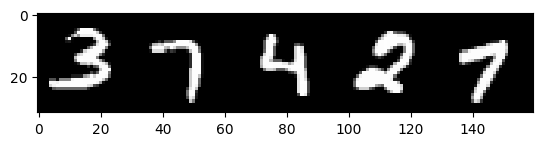

Prediction: 37427


In [18]:
def display_image(x):
    plt.subplots()
    plt.imshow(x[0], cmap="gray")
    plt.show()

def predict(model, x):
    model.eval()
    x = x.unsqueeze(0)
    widths = [x.size(3)]
    output, tgt_lengths, attn_weights = model(x, widths)
    output = output[0][:tgt_lengths[0]+1]
    token_pred = train_dataset.decode_tokens(output)
    str_pred = "".join([p for p in token_pred if p != "<e>"])
    return token_pred, str_pred, attn_weights[0]

test_dataset = MNISTDataset(set_name="test", filepath="./mnist_variable_len_1k.data")
data = test_dataset[3]
x = data["input_img"]
display_image(x)
token_pred, str_pred, attn_weights = predict(model, x)
print(f"Prediction: {str_pred}")

# Visualization

Now, let's analyze the attention weights, iteration per iteration.  

Try with some examples. What kinds of error does the model make?

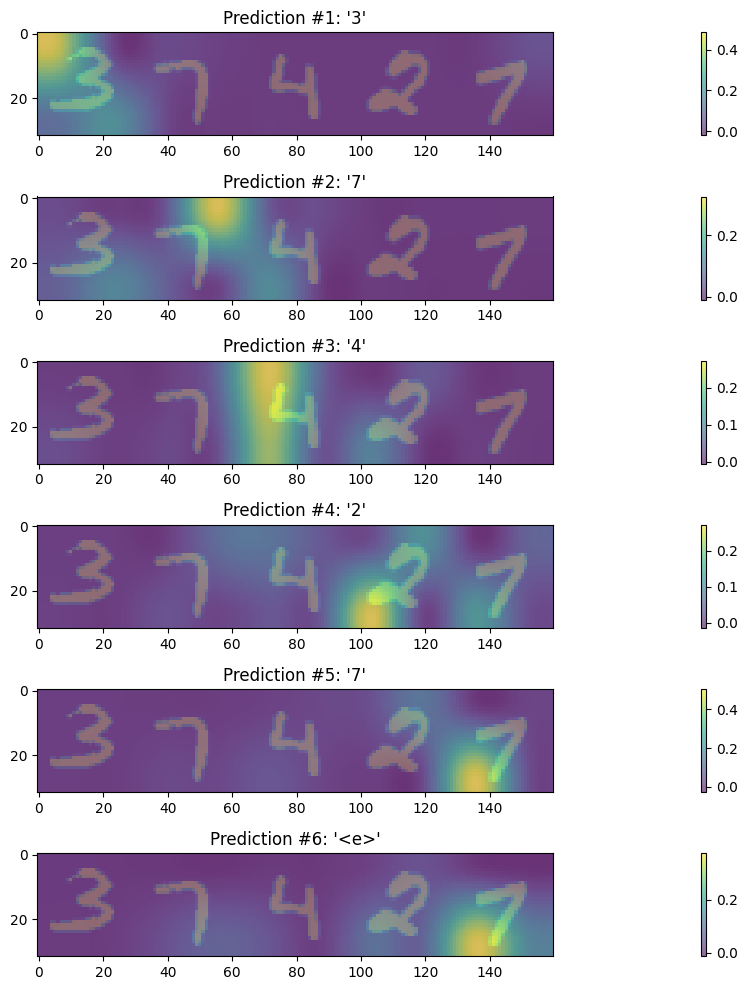

In [19]:
import cv2

def show_iterations(img, weights, preds):
    """
    img: Tensor of size (1, H, W)
    weights: Tensor of size (L, H, W)
    preds: String of length L
    """   
    img = img.detach().numpy()[0]
    weights = [cv2.resize(w.detach().numpy(), (img.shape[1], img.shape[0]), interpolation=cv2.INTER_CUBIC) for w in weights]
    preds = list(preds)
    num_preds = len(preds)
    fig, axes = plt.subplots(nrows=num_preds, figsize=(5*num_preds,10))

    if not isinstance(axes, np.ndarray):
        axes = [axes]

    for i in range(num_preds):
        axes[i].imshow(img, alpha=0.5)
        attn_map = axes[i].imshow(weights[i], cmap='viridis', alpha=0.6)
        axes[i].set_title(f"Prediction #{i+1}: '{preds[i]}'")
        plt.colorbar(attn_map)
    plt.tight_layout()
    plt.show()

show_iterations(x, attn_weights, token_pred)

Prediction: 00285


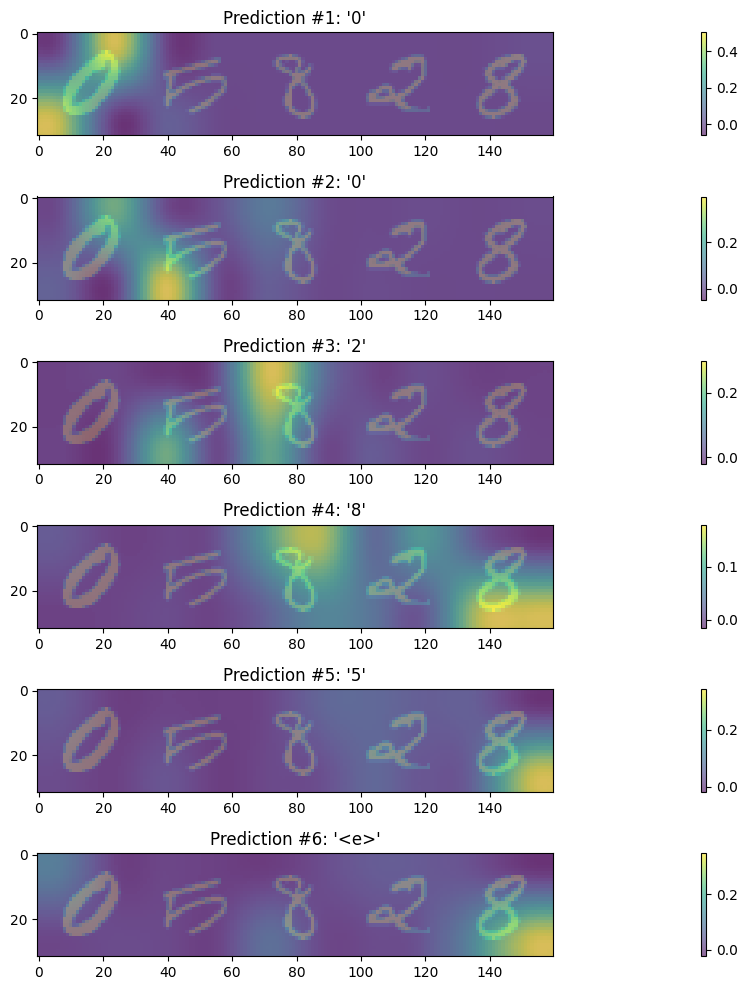

In [20]:
# Prediction #2, #3 an #5: confusing digit with another
# Prediction #4: attention is split on two different "8" digits (good prediction, wrong method)
data = test_dataset[0]
x = data["input_img"]
token_pred, str_pred, attn_weights = predict(model, x)
print(f"Prediction: {str_pred}")
show_iterations(x, attn_weights, token_pred)

Prediction: 3333


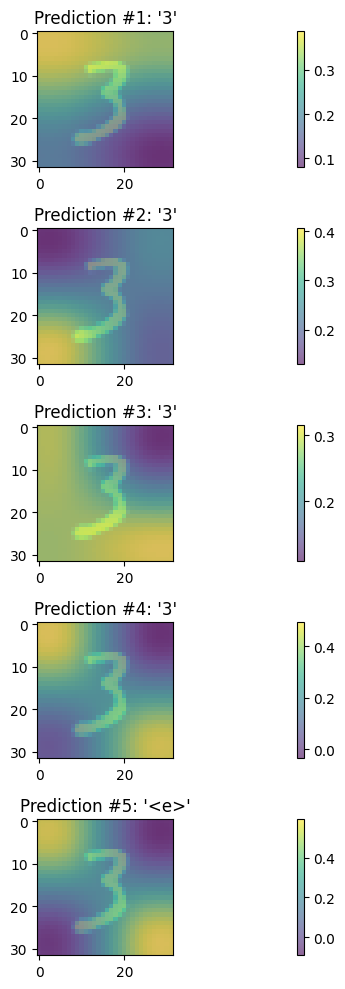

In [21]:
# Looping several times on the same digit
data = test_dataset[1]
x = data["input_img"]
token_pred, str_pred, attn_weights = predict(model, x)
print(f"Prediction: {str_pred}")
show_iterations(x, attn_weights, token_pred)

# To go further: attention implementation

Reminder: the multi-head attention is defined as follows:

$$Q_1 = XW^Q_1 \quad \ldots \quad Q_h = XW^Q_h$$
$$K_1 = YW^K_1 \quad \ldots \quad K_h = YW^K_h$$
$$V_1 = YW^V_1 \quad \ldots \quad V_h = YW^V_h$$

$$O_1 = \text{softmax} \left(\frac{Q_1K_1^T}{\sqrt{d}}\right) V_1 \quad \ldots \quad O_h = \text{softmax}\left(\frac{Q_hK_h^T}{\sqrt{d}}\right) V_h$$

$$Y = \text{concat}(O_1, \ldots, O_h)W^O$$

$d$ refers to the number of dimensions associated to one head.

where $X=Y$ for self-attention.  

It has to be noted that the query/key/value projections of all heads can be computed in parallel among the same densely-connected layer for computation efficiency.

TODO: complete the following class which implements this attention mechanism.

In [22]:
from torch.nn import Linear, Module


class TransformerAttention(Module):

    def __init__(self, dim, num_heads):
        """
        dim: total number of dimensions C
        num_heads: number of attention heads h
        Each head must have the same number of dimensions d
        The number of dimensions is preserved from input to output
        """
        super().__init__()
        assert dim % num_heads == 0, 'dim should be divisible by num_heads'
        self.num_heads = num_heads
        self.head_dim = dim // num_heads
        self.scale_factor = self.head_dim ** -0.5

        # head projections can be merged in a single Linear to parallelize computations
        self.q_proj = Linear(dim, dim, bias=False)
        self.k_proj = Linear(dim, dim, bias=False)
        self.v_proj = Linear(dim, dim, bias=False)

        self.out_proj = Linear(dim, dim, bias=False)  # W^o

    def forward(self, query_seq, key_seq, value_seq, key_padding_mask=None, attn_mask=None):
        """
        Input:  query_seq (B, L_t, C)
                key_seq (B, L_s, C)
                value_seq (B, L_s, C)
                key_padding_mask (B, L_s) = which token to consider in source, to ignore padding
                attn_mask (L_t, L_s) = which source token to consider for each target token, to ignore future prediction with teacher forcing
        Output: (B, L_t, C)
        """
        B, target_len, C = query_seq.size()
        source_len = key_seq.size(1)

        #1 Projection must lead to Q (B, L_t, C), K (B, L_s, C), V (B, L_s, C)
        q = self.q_proj(query_seq)
        k = self.k_proj(key_seq)
        v = self.v_proj(value_seq)

        #2 We will treat all heads in parallel through batch: it must lead to Q (B*h, L_t, d), K (B*h, L_s, d), V (B*h, L_s, d)
        #Be careful with data order, do not mix representations of different tokens together
        # Hint: you will need permute and reshape functions
        q = q.permute(0, 2, 1) # Q (B, C, L_t)
        q = q.reshape(B*self.num_heads, self.head_dim, target_len) # Q (B*h, d, L_t)
        q = q.permute(0, 2, 1) # Q (B*h, L_t, d)

        k = k.permute(0, 2, 1).reshape(B*self.num_heads, self.head_dim, source_len).permute(0, 2, 1) # K (B*h, L_s, d)
        v = v.permute(0, 2, 1).reshape(B*self.num_heads, self.head_dim, source_len).permute(0, 2, 1) # V (B*h, L_s, d)

        #3 Compute scores S=QK/srqt(d), leading to S (B*h, L_t, L_s)
        # S[i, j, k] = how well token j matches with token k with respect to sample/head i
        q = q * self.scale_factor
        attn_weights = torch.bmm(q, k.transpose(-2, -1))

        #4 We need to take into account padded sequences
        # Score for padding token must be set to -Inf to be ignored through the softmax operation
        # Hint: use masked_fill function
        if key_padding_mask is not None:
            attn_weights = attn_weights.view(B, self.num_heads, target_len, source_len)
            attn_weights = attn_weights.masked_fill(
                key_padding_mask.unsqueeze(1).unsqueeze(2),
                float("-inf"),
            )
            attn_weights = attn_weights.view(B * self.num_heads, target_len, source_len)

        #5 We need to take into account the causality of the decoder part
        #The model should not use tokens that have not yet been processed
        if attn_mask is not None:
            attn_mask = attn_mask.unsqueeze(0)
            attn_weights.masked_fill_(attn_mask, float("-inf"))

        #6 Apply softmax to get attention weights alpha (B*h, L_t, L_s)
        attn_weights = attn_weights.softmax(dim=-1)

        #7 Computation of alpha·V (B*h, L_t, d)
        x = torch.bmm(attn_weights, v)

        #8 Dissociate heads for projection
        x = x.permute(0, 2, 1).reshape(B, C, target_len).permute(0, 2, 1) # (B, L_t, C=d*h)
        x = self.out_proj(x)
        return attn_weights, x

Let's check that it provides the same behavior that the pytorch implementation

In [23]:
from torch.nn import MultiheadAttention

B = 2
L = 10
C = 64
H = 2

# Initialize modules
custom_attn = TransformerAttention(dim=C, num_heads=H)
torch_attn = MultiheadAttention(embed_dim=C, num_heads=H, bias=False, add_bias_kv=False, batch_first=True)

# Ensure they have same weights
torch_state_dict = torch_attn.state_dict()
custom_state_dict = {
    "q_proj.weight": torch_state_dict["in_proj_weight"][:C],
    "k_proj.weight": torch_state_dict["in_proj_weight"][C:2*C],
    "v_proj.weight": torch_state_dict["in_proj_weight"][2*C:],
    "out_proj.weight": torch_state_dict["out_proj.weight"]
}
custom_attn.load_state_dict(custom_state_dict)

# Generate fake example
fake_sample = torch.randn((B, L, C), dtype=torch.float)
padding_mask = torch.zeros((B, L), dtype=torch.bool)
padding_mask[0, -2:] = True
mask = torch.zeros((L, L), dtype=torch.bool)
mask[0, 7] = mask[1, 1] = True

# forward pass
out_torch, weights_torch = torch_attn(fake_sample, fake_sample, fake_sample, key_padding_mask=padding_mask, attn_mask=mask)
weights_custom, out_custom = custom_attn(fake_sample, fake_sample, fake_sample, key_padding_mask=padding_mask, attn_mask=mask)

# check equal
assert torch.allclose(out_torch, out_custom, atol=1e-6)